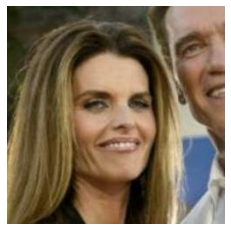

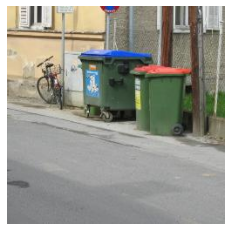

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn.functional as F
import imageio
import zipfile
import shutil
from IPython.display import FileLink, display

def load_images_from_folder(folder):
    images = []
    for subdir, _, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.jpeg', '.jpg')):
                img_path = os.path.join(subdir, file)
                img = mpimg.imread(img_path)
                images.append(img)
    return images

# Load images
human_faces_folder = 'temp_human_faces'
non_human_faces_folder = 'temp_non_human_faces'

human_faces = load_images_from_folder(human_faces_folder)
non_human_faces = load_images_from_folder(non_human_faces_folder)

# Print an image 
def show_image(image):
    plt.imshow(image)
    plt.axis('off')  
    plt.show()


if human_faces:
    show_image(human_faces[0])  
else:
    print("No human face images to display.")

if non_human_faces:
    show_image(non_human_faces[0])  
else:
    print("No non-human face images to display.")

In [2]:
if torch.cuda.is_available():
    torch.device('cuda')
    print("Using cuda")
else:
    torch.device('cpu')
    print("Using cpu")

Using cuda


In [3]:
# Define the custom dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def numpy_to_pil(images):
    pil_images = []
    for img in images:
        if img.max() > 1.0:
            img_normalized = img / 255.0
        else:
            img_normalized = img
        img_uint8 = np.uint8(img_normalized * 255)

        pil_img = Image.fromarray(img_uint8)
        pil_images.append(pil_img)
    return pil_images

In [4]:
# Convert loaded images to PIL format
human_faces_pil = numpy_to_pil(human_faces)
non_human_faces_pil = numpy_to_pil(non_human_faces)

# Create labels
human_labels = [1] * len(human_faces_pil)
non_human_labels = [0] * len(non_human_faces_pil)

# Combine the datasets
all_images = human_faces_pil + non_human_faces_pil
all_labels = human_labels + non_human_labels

# Split the data into training, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.20, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42) 

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
val_dataset = CustomDataset(val_images, val_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)
all_image_dataset = CustomDataset(all_images, all_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
all_image_loader = DataLoader(all_image_dataset, batch_size=32, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 128) 
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 64 * 64) 
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, loss function, and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# The path to save the model
model_path = 'simple_cnn_model.pth'

In [5]:
# Training the model
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Save the model
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

model.load_state_dict(torch.load(model_path))
print(f'Model loaded from {model_path}')

# Check on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the validation images: {100 * correct / total:.2f}%')

Epoch [1/3], Loss: 0.6136
Epoch [2/3], Loss: 0.0324
Epoch [3/3], Loss: 0.0189
Model saved to simple_cnn_model.pth
Model loaded from simple_cnn_model.pth
Accuracy of the model on the validation images: 97.83%


In [5]:
def evaluate_model(test_images, test_labels, model_path, num_images_to_show):
    model = SimpleCNN()
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ])

    test_images_transformed = [transform(img) for img in test_images]
    test_dataset = CustomDataset(test_images_transformed, test_labels, transform=None)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    correct = 0
    total = 0
    confidence_correct = []
    confidence_incorrect = []
    
    # Evaluate the model on the test set
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Calculate confidence
            softmax_outputs = F.softmax(outputs, dim=1)
            for i in range(len(labels)):
                confidence = softmax_outputs[i][predicted[i]].item()
                if predicted[i] == labels[i]:
                    confidence_correct.append(confidence)
                else:
                    confidence_incorrect.append(confidence)

    # Print accuracy and cinfidences
    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    avg_confidence_correct = np.mean(confidence_correct) if confidence_correct else 0
    avg_confidence_incorrect = np.mean(confidence_incorrect) if confidence_incorrect else 0
    print(f'Average confidence for correct predictions: {avg_confidence_correct:.2f}')
    print(f'Average confidence for incorrect predictions: {avg_confidence_incorrect:.2f}')

    # Display images
    for i in range(num_images_to_show):
        img = test_images[i]
        label = test_labels[i]
        img_transformed = transform(img).unsqueeze(0)
        
        with torch.no_grad():
            output = model(img_transformed)
            _, predicted_label = torch.max(output.data, 1)
            confidence = F.softmax(output, dim=1)[0][predicted_label].item()

        plt.imshow(img)
        plt.title(f'Actual: {label}, Predicted: {predicted_label.item()}, Confidence: {confidence:.2f}')
        plt.axis('off')
        plt.show()


Accuracy of the model on the test images: 100.00%
Average confidence for correct predictions: 0.99
Average confidence for incorrect predictions: 0.00


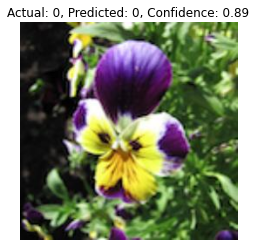

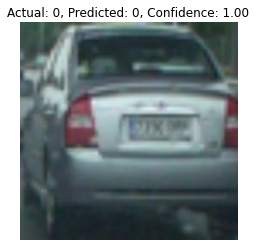

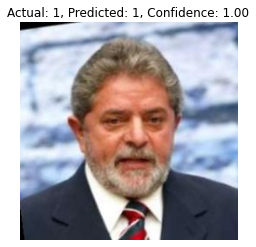

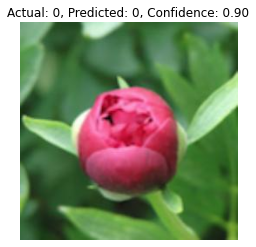

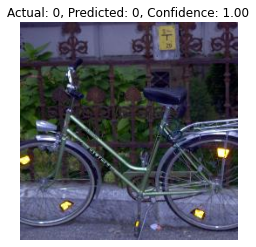

In [6]:
evaluate_model(test_images, test_labels, 'simple_cnn_model.pth', num_images_to_show=5)

In [6]:
all_image_loader = DataLoader(all_image_dataset, batch_size=32, shuffle=False)

In [7]:
def fgsm_attack(model, images, labels, epsilon):
    
    # Make a copy of the images to ensure the original images are not modified
    original_images = images.clone().detach().requires_grad_(True)

    # Forward pass the data through the model
    outputs = model(original_images)
    loss = F.cross_entropy(outputs, labels)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of the loss w.r.t. the images
    loss.backward()

    # Collect the sign of the gradients
    sign_data_grad = original_images.grad.data.sign()

    # Create the adversarial images by adjusting each pixel of the input image
    adv_images = original_images + epsilon * sign_data_grad
    adv_images = torch.clamp(adv_images, 0, 1)

    return adv_images

def create_adversarial_examples(model_path, dataset, epsilon):
    global model, subset_loader

    # Load the best model
    model.load_state_dict(torch.load(model_path))
    print(f'Model loaded from {model_path}')

    # Creating adversarial examples
    model.eval()
    adv_images = []
    adv_labels = []
    original_images = []
    for images, labels in subset_loader:
        class_1_indices = labels == 1
        class_1_images = images[class_1_indices]
        class_1_labels = labels[class_1_indices]

        if len(class_1_images) > 0:
            adv_images_batch = fgsm_attack(model, class_1_images, class_1_labels, epsilon)
            adv_images.extend(adv_images_batch)
            adv_labels.extend(class_1_labels)
            original_images.extend(class_1_images)
            
    adv_images = torch.stack(adv_images)
    adv_labels = torch.stack(adv_labels)
    original_images = torch.stack(original_images)

    return original_images, adv_images

def show_images_side_by_side(original_images, adversarial_images, num_images=20):
 
    for i in range(min(num_images, len(original_images))):
        original_image = original_images[i].permute(1, 2, 0).cpu().detach().numpy()  
        adversarial_image = adversarial_images[i].permute(1, 2, 0).cpu().detach().numpy() 

        original_image = original_image * 255.0
        original_image = original_image.astype(np.uint8)

        adversarial_image = adversarial_image * 255.0
        adversarial_image = adversarial_image.astype(np.uint8)

        # Plot the original and adversarial images
        fig, axs = plt.subplots(1, 2)
        axs[0].imshow(original_image)
        axs[0].set_title('Original Image')
        axs[0].axis('off')

        axs[1].imshow(adversarial_image)
        axs[1].set_title('Adversarial Image')
        axs[1].axis('off')

        plt.show()

def save_adversarial_images_to_zip(adv_images, epsilon):
    
    temp_dir = f'temp_adversarial_images_{epsilon}'
    os.makedirs(temp_dir, exist_ok=True)

    for i, adv_image in enumerate(adv_images):
        img_path = os.path.join(temp_dir, f'adv_image_{i}.jpg')
        adv_image_pil = Image.fromarray((adv_image.permute(1, 2, 0).cpu().detach().numpy() * 255).astype(np.uint8))
        imageio.imwrite(img_path, adv_image_pil)

    # Zip a directory
    def zip_dir(directory, zip_filename):
        with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, _, files in os.walk(directory):
                for file in files:
                    zipf.write(os.path.join(root, file),
                               os.path.relpath(os.path.join(root, file), os.path.join(directory, '..')))

    # Create the zip file
    zip_filename = f'adversarial_images_{epsilon}.zip'
    zip_dir(temp_dir, zip_filename)
    shutil.rmtree(temp_dir)

    return FileLink(zip_filename)

In [13]:
## The adversal images is taking to long to generate, so we will use a subset


original_size = len(all_image_dataset)
new_size = int(0.25 * original_size)

# Randomly select images
indices = np.random.choice(original_size, new_size, replace=False)
subset_dataset = Subset(all_image_dataset, indices)

# Create a DataLoader
subset_loader = DataLoader(subset_dataset, batch_size=32, shuffle=False)


In [14]:
epsilons = [0.01, 0.03]  

for epsilon in epsilons:
    original_images, adversarial_images = create_adversarial_examples(model_path, all_image_dataset, epsilon)
    file_link = save_adversarial_images_to_zip(adversarial_images, epsilon)
    display(file_link)

Model loaded from simple_cnn_model.pth


/home/znebieri/private/ECE 285/Project/adversarial_images_0.01.zip

Model loaded from simple_cnn_model.pth


/home/znebieri/private/ECE 285/Project/adversarial_images_0.03.zip